In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import itertools
warnings.filterwarnings("ignore")

In [6]:
r_df = pd.read_json("./data/info/train.json")
s_df = pd.read_json("./data/info/synthetic.json")

In [7]:
def get_real_test_images(df, fold):
  df = df[df["group"] == fold]
  return df
def get_selected_images(df, fold, count):
  df = df[df["fold"] == fold]
  df = df[df["verieye_status"] == True]
  return df.head(count)
def get_random_group(df, fold, count):
  df = df[df["fold"] == fold]
  return df.sample(n=count)

In [8]:
# 0->Genuine 1->Impostor
def get_fpr_tpr(real_df, fake_df):
  real_df["type"] = 0
  fake_df["type"] = 1
  df = pd.concat([real_df,fake_df], ignore_index=True)
  fprList = []
  tprList = []
  thresholds = np.arange(0.0, 1.01, .01)
  for thold in thresholds:
    FP=0
    TP=0
    for i in range(len(df)):
        if (df["pad_score"][i] > thold):
            if df["type"][i] == 1:
                TP = TP + 1
            if df["type"][i] == 0:
                FP = FP + 1
    fprList.append(FP/float(len(real_df)))
    tprList.append(TP/float(len(fake_df)))
  return fprList, tprList

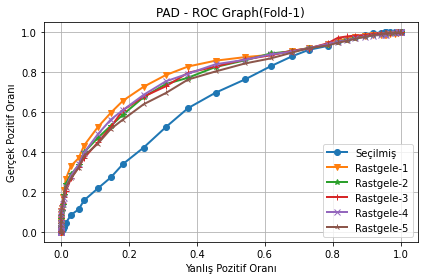

<Figure size 864x720 with 0 Axes>

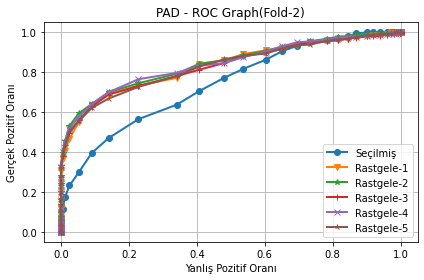

<Figure size 864x720 with 0 Axes>

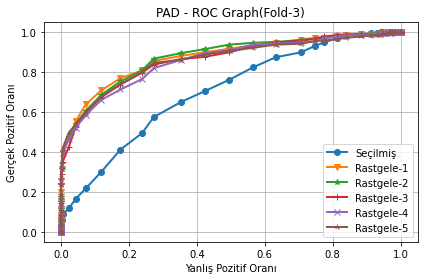

<Figure size 864x720 with 0 Axes>

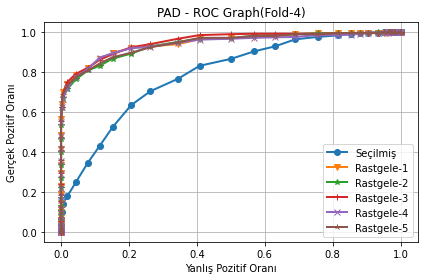

<Figure size 864x720 with 0 Axes>

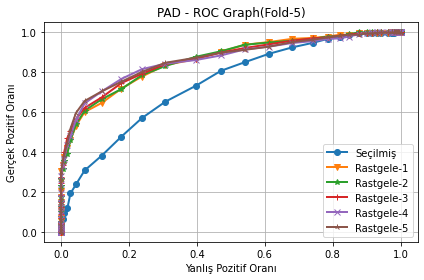

<Figure size 864x720 with 0 Axes>

In [9]:
markers = ["o", "v", "*", "+", "x", "2"]
selecteds = []
randoms = []
for i in range(1,6):
  real_df = get_real_test_images(r_df, i)
  fake_df = get_selected_images(s_df, i, len(real_df))
  fpr, tpr = get_fpr_tpr(real_df, fake_df)
  selecteds.append({"fold":i, "type":"selected", "tpr": tpr, "fpr": fpr})
  plt.plot(fpr, tpr, label="Seçilmiş",linewidth=2, marker = markers[0])
  rand_l = []
  for rand in range(5):
    rand_df = get_random_group(s_df, i, len(real_df))
    fpr_rand, tpr_rand = get_fpr_tpr(real_df, rand_df)
    rand_l.append({"fold":i, "type":"random", "rand": rand+1,"tpr": tpr_rand, "fpr": fpr_rand})
    plt.plot(fpr_rand, tpr_rand, label=f"Rastgele-{rand+1}",linewidth=2, marker=markers[rand+1])
  randoms.append(rand_l)

  plt.grid()
  plt.legend()
  plt.title(f"PAD - ROC Graph(Fold-{i})")
  plt.xlabel("Yanlış Pozitif Oranı")
  plt.ylabel("Gerçek Pozitif Oranı")
  plt.tight_layout()
  # plt.savefig(f"./data/figures/pad-roc-{i}", facecolor="white")
  plt.figure(figsize=(12,10))
  plt.show()

In [12]:
selecteds_fpr_avg = np.sum([item["fpr"] for item in selecteds], axis=0) / 5
selecteds_tpr_avg = np.sum([item["tpr"] for item in selecteds], axis=0) / 5
rand_fpr_avgs = []
rand_tpr_avgs = []
df = pd.DataFrame(randoms)
for idx,row in enumerate(randoms):
  items = df[idx]
  rand_fpr_avgs.append(np.sum([item["fpr"] for item in items], axis=0) / 5)
  rand_tpr_avgs.append(np.sum([item["tpr"] for item in items],axis=0)/ 5)

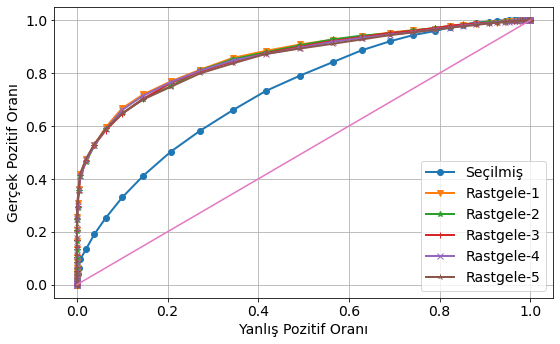

In [54]:

intersections=[]

from shapely.geometry import LineString
plt.figure(figsize=(8,5))
plt.plot(selecteds_fpr_avg, selecteds_tpr_avg, label="Seçilmiş",linewidth=2, marker = markers[0])
first_line = LineString(np.column_stack((selecteds_fpr_avg, selecteds_tpr_avg)))
second_line = LineString(np.column_stack(([0,1], [1,0])))
intersection = first_line.intersection(second_line)
intersections.append({"Name":"Seçilmiş", "Points": intersection.xy})
for rand in range(5):
  fpr_avg_p= rand_fpr_avgs[rand]
  tpr_avg_p = rand_tpr_avgs[rand]
  plt.plot(fpr_avg_p,tpr_avg_p , label=f"Rastgele-{rand+1}",linewidth=2, marker=markers[rand+1])
  first_line = LineString(np.column_stack((fpr_avg_p, tpr_avg_p)))
  second_line = LineString(np.column_stack(([0,1], [1,0])))
  intersection = first_line.intersection(second_line)
  intersections.append({"Name":f"Rastgele-{rand+1}", "Points": intersection.xy})

plt.grid()
plt.legend()
# plt.title(f"PAD - ROC Graph")
plt.rcParams.update({'font.size': 14})
plt.xlabel("Yanlış Pozitif Oranı")
plt.ylabel("Gerçek Pozitif Oranı")

plt.tight_layout()
# idx = np.argwhere(np.diff(np.sign( - g))).flatten()
# plt.plot(x[idx], f[idx], 'ro')
# plt.savefig("./data/figures/pad-roc-avg.png", facecolor="white")
plt.show()

In [53]:
[(intersection["Name"],intersection["Points"][0][0]) for intersection in intersections]

[('Seçilmiş', 0.3419709086028778),
 ('Rastgele-1', 0.22149873264231543),
 ('Rastgele-2', 0.22905233200987066),
 ('Rastgele-3', 0.2252549203848115),
 ('Rastgele-4', 0.2231412939822768),
 ('Rastgele-5', 0.23199257606267767)]

In [47]:
from scipy.optimize import brentq
from scipy.interpolate import interp1d
eer = brentq(lambda x : 1. - x - interp1d(selecteds_fpr_avg, selecteds_tpr_avg)(x), 0., 1.)
# thresh = interp1d(fpr, thresholds)(eer)

In [48]:
eer

0.3419709086028778